In [2]:
import numpy as np
import json

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input

In [4]:
vgg16 = VGG16(weights='imagenet')

In [5]:
vgg16.save('vgg16.h5')

In [6]:
def prepare_image(img_path):
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [7]:
CLASS_INDEX = None

In [8]:
CLASS_INDEX_PATH = './imagenet-class-index.json'

In [9]:
def get_predictions(preds, top=5):
    global CLASS_INDEX
    
    CLASS_INDEX = json.load(open(CLASS_INDEX_PATH))
    
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x:x[2], reverse=True)
        results.append(result)
    return results

In [10]:
y = prepare_image('./L0_007fc50de2f321795f2629d0002dab3a.jpg')

In [11]:
preds = vgg16.predict(y)

In [12]:
preds.shape

(1, 1000)

In [13]:
print(get_predictions(preds, top=5))

[[('n12985857', 'coral_fungus', 0.70643306), ('n03530642', 'honeycomb', 0.17987218), ('n13052670', 'hen-of-the-woods', 0.059125226), ('n13037406', 'gyromitra', 0.020912662), ('n13040303', 'stinkhorn', 0.007107349)]]


In [14]:
from collections import Counter, defaultdict
import os
import pickle as pk

In [18]:
def get_SEM_categories():
    d = defaultdict(float)
    img_list = os.listdir('./Data_Main/all')
    for i, img_path in enumerate(img_list):
        img = prepare_image('./Data_Main/all/'+img_path)
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            d[j[0:2]] += j[2]
        if i % 100 == 0:
            print(i,'/', len(img_list), 'complete')
    return Counter(d)

In [19]:
cat_counter = get_SEM_categories()

0 / 18577 complete
100 / 18577 complete
200 / 18577 complete
300 / 18577 complete
400 / 18577 complete
500 / 18577 complete
600 / 18577 complete
700 / 18577 complete
800 / 18577 complete
900 / 18577 complete
1000 / 18577 complete
1100 / 18577 complete
1200 / 18577 complete
1300 / 18577 complete
1400 / 18577 complete
1500 / 18577 complete
1600 / 18577 complete
1700 / 18577 complete
1800 / 18577 complete
1900 / 18577 complete
2000 / 18577 complete
2100 / 18577 complete
2200 / 18577 complete
2300 / 18577 complete
2400 / 18577 complete
2500 / 18577 complete
2600 / 18577 complete
2700 / 18577 complete
2800 / 18577 complete
2900 / 18577 complete
3000 / 18577 complete
3100 / 18577 complete
3200 / 18577 complete
3300 / 18577 complete
3400 / 18577 complete
3500 / 18577 complete
3600 / 18577 complete
3700 / 18577 complete
3800 / 18577 complete
3900 / 18577 complete
4000 / 18577 complete
4100 / 18577 complete
4200 / 18577 complete
4300 / 18577 complete
4400 / 18577 complete
4500 / 18577 complete


In [20]:
with open('cat_counter.pk','wb') as f:
    pk.dump(cat_counter,f,-1)

In [21]:
cat_list = [k for k,v in cat_counter.most_common()[:27]]

In [22]:
cat_list

[('n04118776', 'rule'),
 ('n01930112', 'nematode'),
 ('n04376876', 'syringe'),
 ('n03291819', 'envelope'),
 ('n03729826', 'matchstick'),
 ('n03804744', 'nail'),
 ('n06359193', 'web_site'),
 ('n04238763', 'slide_rule'),
 ('n03857828', 'oscilloscope'),
 ('n03930313', 'picket_fence'),
 ('n07248320', 'book_jacket'),
 ('n03633091', 'ladle'),
 ('n04040759', 'radiator'),
 ('n03223299', 'doormat'),
 ('n03733281', 'maze'),
 ('n03658185', 'letter_opener'),
 ('n03530642', 'honeycomb'),
 ('n04152593', 'screen'),
 ('n03782006', 'monitor'),
 ('n04041544', 'radio'),
 ('n03627232', 'knot'),
 ('n12985857', 'coral_fungus'),
 ('n03777754', 'modem'),
 ('n02219486', 'ant'),
 ('n03000684', 'chain_saw'),
 ('n03250847', 'drumstick'),
 ('n03000134', 'chainlink_fence')]

In [24]:
def SEM_categories_gate(image_path, cat_list):
    img = prepare_image(image_path)
    out = vgg16.predict(img)
    top = get_predictions(out,top=5)
    print('validating that this is a microscopy image...')
    for j in top[0]:
        if j[0:2] in cat_list:
            print( (j[0:2]))
            return "Validation complete - proceed to classification"
    return "Are you sure this is a microscopy image?" 

In [27]:
SEM_categories_gate('./L3_3ec2432388fe19ac6fbf3bdb293f897e.jpg', cat_list)

validating that this is a microscopy image...
('n04118776', 'rule')


'Validation complete - proceed to classification'

In [65]:
import os
import glob
import datetime

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model

from sklearn.preprocessing import LabelEncoder
import numpy as np
import h5py
import json
import time

In [66]:
config={
    "model" : "vgg16",
    "weights": "imagenet",
    "include_top" : False,
    
    "train_path" : "./Data_Main/training",
    "test_path" : "./Data_Main/validation",
    "features_path" : "./Model/features.h5",
    "labels_path" : "./Model/labels.h5",
    "results" : "./Model/results.txt",
    "classifier_path" : "./Model/classifier.pickle",
    "model_path" : "./Model/model",
    
    "test_size" : 0.20,
    "seed" : 9,
    "num_classes" : 2
}

In [67]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [68]:
model_name = config["model"]
weights = config["weights"]
include_top = config["include_top"]
train_path = config["train_path"]
features_path = config["features_path"]
labels_path = config["labels_path"]
test_size = config["test_size"]
resutls = config["results"]
model_path =config["model_path"]

In [69]:
if model_name == "vgg16":
    base_model = VGG16(weights=weights)
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    image_size = (224,224)
else:
    base_model = None
print ("Sucessfully loaded base model and model...")

Sucessfully loaded base model and model...


C:\Users\Mehrtoos\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
train_labels = os.listdir(train_path)

In [71]:
train_labels

['Biological',
 'Fibres',
 'Films_Coated_Surface',
 'MEMS_devices_and_electrodes',
 'Nanowires',
 'Particles',
 'Patterned_surface',
 'Porous_Sponge',
 'Powder',
 'Tips']

In [72]:
train_labels = os.listdir(train_path)

print("Encoding labels...")
le = LabelEncoder()
le.fit([t1 for t1 in train_labels])
    
features = []
labels = []
    
count = 1
for i, label in enumerate(train_labels):
    cur_path = train_path + "/" + label
    count = 1
    for image_path in glob.glob(cur_path + "/*.jpg"):
        img = image.load_img(image_path, target_size=image_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x)
        flat = feature.flatten()
        features.append(flat)
        labels.append(label)
        print("Processed - " + str(count))
        count +=1
    print("Completed label - " + label)

le = LabelEncoder()
le_labels = le.fit_transform(labels)

print("Training labels: {}".format(le_labels))
print("Training labels shape: {}".format(le_labels.shape))

Encoding labels...
Processed - 1
Processed - 2
Processed - 3
Processed - 4
Processed - 5
Processed - 6
Processed - 7
Processed - 8
Processed - 9
Processed - 10
Processed - 11
Processed - 12
Processed - 13
Processed - 14
Processed - 15
Processed - 16
Processed - 17
Processed - 18
Processed - 19
Processed - 20
Processed - 21
Processed - 22
Processed - 23
Processed - 24
Processed - 25
Processed - 26
Processed - 27
Processed - 28
Processed - 29
Processed - 30
Processed - 31
Processed - 32
Processed - 33
Processed - 34
Processed - 35
Processed - 36
Processed - 37
Processed - 38
Processed - 39
Processed - 40
Processed - 41
Processed - 42
Processed - 43
Processed - 44
Processed - 45
Processed - 46
Processed - 47
Processed - 48
Processed - 49
Processed - 50
Processed - 51
Processed - 52
Processed - 53
Processed - 54
Processed - 55
Processed - 56
Processed - 57
Processed - 58
Processed - 59
Processed - 60
Processed - 61
Processed - 62
Processed - 63
Processed - 64
Processed - 65
Processed - 66


Processed - 519
Processed - 520
Processed - 521
Processed - 522
Processed - 523
Processed - 524
Processed - 525
Processed - 526
Processed - 527
Processed - 528
Processed - 529
Processed - 530
Processed - 531
Processed - 532
Processed - 533
Processed - 534
Processed - 535
Processed - 536
Processed - 537
Processed - 538
Processed - 539
Processed - 540
Processed - 541
Processed - 542
Processed - 543
Processed - 544
Processed - 545
Processed - 546
Processed - 547
Processed - 548
Processed - 549
Processed - 550
Processed - 551
Processed - 552
Processed - 553
Processed - 554
Processed - 555
Processed - 556
Processed - 557
Processed - 558
Processed - 559
Processed - 560
Processed - 561
Processed - 562
Processed - 563
Processed - 564
Processed - 565
Processed - 566
Processed - 567
Processed - 568
Processed - 569
Processed - 570
Processed - 571
Processed - 572
Processed - 573
Processed - 574
Processed - 575
Processed - 576
Processed - 577
Processed - 578
Processed - 579
Processed - 580
Processe

Processed - 82
Processed - 83
Processed - 84
Processed - 85
Processed - 86
Processed - 87
Processed - 88
Processed - 89
Processed - 90
Processed - 91
Processed - 92
Processed - 93
Processed - 94
Processed - 95
Processed - 96
Processed - 97
Processed - 98
Processed - 99
Processed - 100
Processed - 101
Processed - 102
Processed - 103
Processed - 104
Processed - 105
Processed - 106
Processed - 107
Processed - 108
Processed - 109
Processed - 110
Processed - 111
Processed - 112
Processed - 113
Processed - 114
Processed - 115
Processed - 116
Processed - 117
Processed - 118
Processed - 119
Processed - 120
Processed - 121
Processed - 122
Processed - 123
Processed - 124
Processed - 125
Processed - 126
Processed - 127
Processed - 128
Processed - 129
Processed - 130
Processed - 131
Processed - 132
Processed - 133
Processed - 134
Processed - 135
Processed - 136
Processed - 137
Processed - 138
Processed - 139
Processed - 140
Processed - 141
Processed - 142
Processed - 143
Processed - 144
Processed 

Processed - 144
Processed - 145
Processed - 146
Processed - 147
Processed - 148
Processed - 149
Processed - 150
Processed - 151
Processed - 152
Processed - 153
Processed - 154
Processed - 155
Processed - 156
Processed - 157
Processed - 158
Processed - 159
Processed - 160
Processed - 161
Processed - 162
Processed - 163
Processed - 164
Processed - 165
Processed - 166
Processed - 167
Processed - 168
Processed - 169
Processed - 170
Processed - 171
Processed - 172
Processed - 173
Processed - 174
Processed - 175
Processed - 176
Processed - 177
Processed - 178
Processed - 179
Processed - 180
Processed - 181
Processed - 182
Processed - 183
Processed - 184
Processed - 185
Processed - 186
Processed - 187
Processed - 188
Processed - 189
Processed - 190
Processed - 191
Processed - 192
Processed - 193
Processed - 194
Processed - 195
Processed - 196
Processed - 197
Processed - 198
Processed - 199
Processed - 200
Processed - 201
Processed - 202
Processed - 203
Processed - 204
Processed - 205
Processe

Processed - 657
Processed - 658
Processed - 659
Processed - 660
Processed - 661
Processed - 662
Processed - 663
Processed - 664
Processed - 665
Processed - 666
Processed - 667
Processed - 668
Processed - 669
Processed - 670
Processed - 671
Processed - 672
Processed - 673
Processed - 674
Processed - 675
Processed - 676
Processed - 677
Processed - 678
Processed - 679
Processed - 680
Processed - 681
Processed - 682
Processed - 683
Processed - 684
Processed - 685
Processed - 686
Processed - 687
Processed - 688
Processed - 689
Processed - 690
Processed - 691
Processed - 692
Processed - 693
Processed - 694
Processed - 695
Processed - 696
Processed - 697
Processed - 698
Processed - 699
Processed - 700
Processed - 701
Processed - 702
Processed - 703
Processed - 704
Processed - 705
Processed - 706
Processed - 707
Processed - 708
Processed - 709
Processed - 710
Processed - 711
Processed - 712
Processed - 713
Processed - 714
Processed - 715
Processed - 716
Processed - 717
Processed - 718
Processe

Processed - 1160
Processed - 1161
Processed - 1162
Processed - 1163
Processed - 1164
Processed - 1165
Processed - 1166
Processed - 1167
Processed - 1168
Processed - 1169
Processed - 1170
Processed - 1171
Processed - 1172
Processed - 1173
Processed - 1174
Processed - 1175
Processed - 1176
Processed - 1177
Processed - 1178
Processed - 1179
Processed - 1180
Processed - 1181
Processed - 1182
Processed - 1183
Processed - 1184
Processed - 1185
Processed - 1186
Processed - 1187
Processed - 1188
Processed - 1189
Processed - 1190
Processed - 1191
Processed - 1192
Processed - 1193
Processed - 1194
Processed - 1195
Processed - 1196
Processed - 1197
Processed - 1198
Processed - 1199
Processed - 1200
Processed - 1201
Processed - 1202
Processed - 1203
Processed - 1204
Processed - 1205
Processed - 1206
Processed - 1207
Processed - 1208
Processed - 1209
Processed - 1210
Processed - 1211
Processed - 1212
Processed - 1213
Processed - 1214
Processed - 1215
Processed - 1216
Processed - 1217
Processed - 12

Processed - 1642
Processed - 1643
Processed - 1644
Processed - 1645
Processed - 1646
Processed - 1647
Processed - 1648
Processed - 1649
Processed - 1650
Processed - 1651
Processed - 1652
Processed - 1653
Processed - 1654
Processed - 1655
Processed - 1656
Processed - 1657
Processed - 1658
Processed - 1659
Processed - 1660
Processed - 1661
Processed - 1662
Processed - 1663
Processed - 1664
Processed - 1665
Processed - 1666
Processed - 1667
Processed - 1668
Processed - 1669
Processed - 1670
Processed - 1671
Processed - 1672
Processed - 1673
Processed - 1674
Processed - 1675
Processed - 1676
Processed - 1677
Processed - 1678
Processed - 1679
Processed - 1680
Processed - 1681
Processed - 1682
Processed - 1683
Processed - 1684
Processed - 1685
Processed - 1686
Processed - 1687
Processed - 1688
Processed - 1689
Processed - 1690
Processed - 1691
Processed - 1692
Processed - 1693
Processed - 1694
Processed - 1695
Processed - 1696
Processed - 1697
Processed - 1698
Processed - 1699
Processed - 17

Processed - 2124
Processed - 2125
Processed - 2126
Processed - 2127
Processed - 2128
Processed - 2129
Processed - 2130
Processed - 2131
Processed - 2132
Processed - 2133
Processed - 2134
Processed - 2135
Processed - 2136
Processed - 2137
Processed - 2138
Processed - 2139
Processed - 2140
Processed - 2141
Processed - 2142
Processed - 2143
Processed - 2144
Processed - 2145
Processed - 2146
Processed - 2147
Processed - 2148
Processed - 2149
Processed - 2150
Processed - 2151
Processed - 2152
Processed - 2153
Processed - 2154
Processed - 2155
Processed - 2156
Processed - 2157
Processed - 2158
Processed - 2159
Processed - 2160
Processed - 2161
Processed - 2162
Processed - 2163
Processed - 2164
Processed - 2165
Processed - 2166
Processed - 2167
Processed - 2168
Processed - 2169
Processed - 2170
Processed - 2171
Processed - 2172
Processed - 2173
Processed - 2174
Processed - 2175
Processed - 2176
Processed - 2177
Processed - 2178
Processed - 2179
Processed - 2180
Processed - 2181
Processed - 21

Processed - 2606
Processed - 2607
Processed - 2608
Processed - 2609
Processed - 2610
Processed - 2611
Processed - 2612
Processed - 2613
Processed - 2614
Processed - 2615
Processed - 2616
Processed - 2617
Processed - 2618
Processed - 2619
Processed - 2620
Processed - 2621
Processed - 2622
Processed - 2623
Processed - 2624
Processed - 2625
Processed - 2626
Processed - 2627
Processed - 2628
Processed - 2629
Processed - 2630
Processed - 2631
Processed - 2632
Processed - 2633
Processed - 2634
Processed - 2635
Processed - 2636
Processed - 2637
Processed - 2638
Processed - 2639
Processed - 2640
Processed - 2641
Processed - 2642
Processed - 2643
Processed - 2644
Processed - 2645
Processed - 2646
Processed - 2647
Processed - 2648
Processed - 2649
Processed - 2650
Processed - 2651
Processed - 2652
Processed - 2653
Processed - 2654
Processed - 2655
Processed - 2656
Processed - 2657
Processed - 2658
Processed - 2659
Processed - 2660
Processed - 2661
Processed - 2662
Processed - 2663
Processed - 26

Processed - 3088
Processed - 3089
Processed - 3090
Processed - 3091
Processed - 3092
Processed - 3093
Processed - 3094
Processed - 3095
Processed - 3096
Processed - 3097
Processed - 3098
Processed - 3099
Processed - 3100
Processed - 3101
Processed - 3102
Processed - 3103
Processed - 3104
Processed - 3105
Processed - 3106
Processed - 3107
Processed - 3108
Processed - 3109
Processed - 3110
Processed - 3111
Processed - 3112
Processed - 3113
Processed - 3114
Processed - 3115
Processed - 3116
Processed - 3117
Processed - 3118
Processed - 3119
Processed - 3120
Processed - 3121
Processed - 3122
Processed - 3123
Processed - 3124
Processed - 3125
Processed - 3126
Processed - 3127
Processed - 3128
Processed - 3129
Processed - 3130
Processed - 3131
Processed - 3132
Processed - 3133
Processed - 3134
Processed - 3135
Processed - 3136
Processed - 3137
Processed - 3138
Processed - 3139
Processed - 3140
Processed - 3141
Processed - 3142
Processed - 3143
Processed - 3144
Processed - 3145
Processed - 31

Processed - 3570
Processed - 3571
Processed - 3572
Processed - 3573
Processed - 3574
Processed - 3575
Processed - 3576
Processed - 3577
Processed - 3578
Processed - 3579
Processed - 3580
Processed - 3581
Processed - 3582
Processed - 3583
Processed - 3584
Processed - 3585
Processed - 3586
Processed - 3587
Processed - 3588
Processed - 3589
Processed - 3590
Processed - 3591
Processed - 3592
Processed - 3593
Processed - 3594
Processed - 3595
Processed - 3596
Processed - 3597
Processed - 3598
Processed - 3599
Processed - 3600
Processed - 3601
Processed - 3602
Processed - 3603
Processed - 3604
Processed - 3605
Processed - 3606
Processed - 3607
Processed - 3608
Processed - 3609
Processed - 3610
Processed - 3611
Processed - 3612
Processed - 3613
Processed - 3614
Processed - 3615
Processed - 3616
Processed - 3617
Processed - 3618
Processed - 3619
Processed - 3620
Processed - 3621
Processed - 3622
Processed - 3623
Processed - 3624
Processed - 3625
Processed - 3626
Processed - 3627
Processed - 36

Processed - 4052
Processed - 4053
Processed - 4054
Processed - 4055
Processed - 4056
Processed - 4057
Processed - 4058
Processed - 4059
Processed - 4060
Processed - 4061
Processed - 4062
Processed - 4063
Processed - 4064
Processed - 4065
Processed - 4066
Processed - 4067
Processed - 4068
Processed - 4069
Processed - 4070
Processed - 4071
Processed - 4072
Processed - 4073
Processed - 4074
Processed - 4075
Processed - 4076
Processed - 4077
Processed - 4078
Processed - 4079
Processed - 4080
Processed - 4081
Processed - 4082
Processed - 4083
Processed - 4084
Processed - 4085
Processed - 4086
Processed - 4087
Processed - 4088
Processed - 4089
Processed - 4090
Processed - 4091
Processed - 4092
Processed - 4093
Processed - 4094
Processed - 4095
Processed - 4096
Processed - 4097
Processed - 4098
Processed - 4099
Processed - 4100
Processed - 4101
Processed - 4102
Processed - 4103
Processed - 4104
Processed - 4105
Processed - 4106
Processed - 4107
Processed - 4108
Processed - 4109
Processed - 41

Processed - 404
Processed - 405
Processed - 406
Processed - 407
Processed - 408
Processed - 409
Processed - 410
Processed - 411
Processed - 412
Processed - 413
Processed - 414
Processed - 415
Processed - 416
Processed - 417
Processed - 418
Processed - 419
Processed - 420
Processed - 421
Processed - 422
Processed - 423
Processed - 424
Processed - 425
Processed - 426
Processed - 427
Processed - 428
Processed - 429
Processed - 430
Processed - 431
Processed - 432
Processed - 433
Processed - 434
Processed - 435
Processed - 436
Processed - 437
Processed - 438
Processed - 439
Processed - 440
Processed - 441
Processed - 442
Processed - 443
Processed - 444
Processed - 445
Processed - 446
Processed - 447
Processed - 448
Processed - 449
Processed - 450
Processed - 451
Processed - 452
Processed - 453
Processed - 454
Processed - 455
Processed - 456
Processed - 457
Processed - 458
Processed - 459
Processed - 460
Processed - 461
Processed - 462
Processed - 463
Processed - 464
Processed - 465
Processe

Processed - 917
Processed - 918
Processed - 919
Processed - 920
Processed - 921
Processed - 922
Processed - 923
Processed - 924
Processed - 925
Processed - 926
Processed - 927
Processed - 928
Processed - 929
Processed - 930
Processed - 931
Processed - 932
Processed - 933
Processed - 934
Processed - 935
Processed - 936
Processed - 937
Processed - 938
Processed - 939
Processed - 940
Processed - 941
Processed - 942
Processed - 943
Processed - 944
Processed - 945
Processed - 946
Processed - 947
Processed - 948
Processed - 949
Processed - 950
Processed - 951
Processed - 952
Processed - 953
Processed - 954
Processed - 955
Processed - 956
Processed - 957
Processed - 958
Processed - 959
Processed - 960
Processed - 961
Processed - 962
Processed - 963
Processed - 964
Processed - 965
Processed - 966
Processed - 967
Processed - 968
Processed - 969
Processed - 970
Processed - 971
Processed - 972
Processed - 973
Processed - 974
Processed - 975
Processed - 976
Processed - 977
Processed - 978
Processe

Processed - 1404
Processed - 1405
Processed - 1406
Processed - 1407
Processed - 1408
Processed - 1409
Processed - 1410
Processed - 1411
Processed - 1412
Processed - 1413
Processed - 1414
Processed - 1415
Processed - 1416
Processed - 1417
Processed - 1418
Processed - 1419
Processed - 1420
Processed - 1421
Processed - 1422
Processed - 1423
Processed - 1424
Processed - 1425
Processed - 1426
Processed - 1427
Processed - 1428
Processed - 1429
Processed - 1430
Processed - 1431
Processed - 1432
Processed - 1433
Processed - 1434
Processed - 1435
Processed - 1436
Processed - 1437
Processed - 1438
Processed - 1439
Processed - 1440
Processed - 1441
Processed - 1442
Processed - 1443
Processed - 1444
Processed - 1445
Processed - 1446
Processed - 1447
Processed - 1448
Processed - 1449
Processed - 1450
Processed - 1451
Processed - 1452
Processed - 1453
Processed - 1454
Processed - 1455
Processed - 1456
Processed - 1457
Processed - 1458
Processed - 1459
Processed - 1460
Processed - 1461
Processed - 14

Processed - 1886
Processed - 1887
Processed - 1888
Processed - 1889
Processed - 1890
Processed - 1891
Processed - 1892
Processed - 1893
Processed - 1894
Processed - 1895
Processed - 1896
Processed - 1897
Processed - 1898
Processed - 1899
Processed - 1900
Processed - 1901
Processed - 1902
Processed - 1903
Processed - 1904
Processed - 1905
Processed - 1906
Processed - 1907
Processed - 1908
Processed - 1909
Processed - 1910
Processed - 1911
Processed - 1912
Processed - 1913
Processed - 1914
Processed - 1915
Processed - 1916
Processed - 1917
Processed - 1918
Processed - 1919
Processed - 1920
Processed - 1921
Processed - 1922
Processed - 1923
Processed - 1924
Processed - 1925
Processed - 1926
Processed - 1927
Processed - 1928
Processed - 1929
Processed - 1930
Processed - 1931
Processed - 1932
Processed - 1933
Processed - 1934
Processed - 1935
Processed - 1936
Processed - 1937
Processed - 1938
Processed - 1939
Processed - 1940
Processed - 1941
Processed - 1942
Processed - 1943
Processed - 19

Processed - 2368
Processed - 2369
Processed - 2370
Processed - 2371
Processed - 2372
Processed - 2373
Processed - 2374
Processed - 2375
Processed - 2376
Processed - 2377
Processed - 2378
Processed - 2379
Processed - 2380
Processed - 2381
Processed - 2382
Processed - 2383
Processed - 2384
Processed - 2385
Processed - 2386
Processed - 2387
Processed - 2388
Processed - 2389
Processed - 2390
Processed - 2391
Processed - 2392
Processed - 2393
Processed - 2394
Processed - 2395
Processed - 2396
Processed - 2397
Processed - 2398
Processed - 2399
Processed - 2400
Processed - 2401
Processed - 2402
Processed - 2403
Processed - 2404
Processed - 2405
Processed - 2406
Processed - 2407
Processed - 2408
Processed - 2409
Processed - 2410
Processed - 2411
Processed - 2412
Processed - 2413
Processed - 2414
Processed - 2415
Processed - 2416
Processed - 2417
Processed - 2418
Processed - 2419
Processed - 2420
Processed - 2421
Processed - 2422
Processed - 2423
Processed - 2424
Processed - 2425
Processed - 24

Processed - 2850
Processed - 2851
Processed - 2852
Processed - 2853
Processed - 2854
Processed - 2855
Processed - 2856
Processed - 2857
Processed - 2858
Processed - 2859
Processed - 2860
Processed - 2861
Processed - 2862
Processed - 2863
Processed - 2864
Processed - 2865
Processed - 2866
Processed - 2867
Processed - 2868
Processed - 2869
Processed - 2870
Processed - 2871
Processed - 2872
Processed - 2873
Processed - 2874
Processed - 2875
Processed - 2876
Processed - 2877
Processed - 2878
Processed - 2879
Processed - 2880
Processed - 2881
Processed - 2882
Processed - 2883
Processed - 2884
Processed - 2885
Processed - 2886
Processed - 2887
Processed - 2888
Processed - 2889
Processed - 2890
Processed - 2891
Processed - 2892
Processed - 2893
Processed - 2894
Processed - 2895
Processed - 2896
Processed - 2897
Processed - 2898
Processed - 2899
Processed - 2900
Processed - 2901
Processed - 2902
Processed - 2903
Processed - 2904
Processed - 2905
Processed - 2906
Processed - 2907
Processed - 29

Processed - 3332
Processed - 3333
Processed - 3334
Processed - 3335
Processed - 3336
Processed - 3337
Processed - 3338
Processed - 3339
Processed - 3340
Processed - 3341
Processed - 3342
Processed - 3343
Processed - 3344
Processed - 3345
Processed - 3346
Processed - 3347
Processed - 3348
Processed - 3349
Processed - 3350
Processed - 3351
Processed - 3352
Processed - 3353
Processed - 3354
Processed - 3355
Processed - 3356
Processed - 3357
Processed - 3358
Processed - 3359
Processed - 3360
Processed - 3361
Processed - 3362
Processed - 3363
Processed - 3364
Processed - 3365
Processed - 3366
Processed - 3367
Processed - 3368
Processed - 3369
Processed - 3370
Processed - 3371
Processed - 3372
Processed - 3373
Processed - 3374
Processed - 3375
Processed - 3376
Processed - 3377
Processed - 3378
Processed - 3379
Processed - 3380
Processed - 3381
Processed - 3382
Processed - 3383
Processed - 3384
Processed - 3385
Processed - 3386
Processed - 3387
Processed - 3388
Processed - 3389
Processed - 33

Processed - 173
Processed - 174
Processed - 175
Processed - 176
Processed - 177
Processed - 178
Processed - 179
Processed - 180
Processed - 181
Processed - 182
Processed - 183
Processed - 184
Processed - 185
Processed - 186
Processed - 187
Processed - 188
Processed - 189
Processed - 190
Processed - 191
Processed - 192
Processed - 193
Processed - 194
Processed - 195
Processed - 196
Processed - 197
Processed - 198
Processed - 199
Processed - 200
Processed - 201
Processed - 202
Processed - 203
Processed - 204
Processed - 205
Processed - 206
Processed - 207
Processed - 208
Processed - 209
Processed - 210
Processed - 211
Processed - 212
Processed - 213
Processed - 214
Processed - 215
Processed - 216
Processed - 217
Processed - 218
Processed - 219
Processed - 220
Processed - 221
Processed - 222
Processed - 223
Processed - 224
Processed - 225
Processed - 226
Processed - 227
Processed - 228
Processed - 229
Processed - 230
Processed - 231
Processed - 232
Processed - 233
Processed - 234
Processe

Processed - 686
Processed - 687
Processed - 688
Processed - 689
Processed - 690
Processed - 691
Processed - 692
Processed - 693
Processed - 694
Processed - 695
Processed - 696
Processed - 697
Processed - 698
Processed - 699
Processed - 700
Processed - 701
Processed - 702
Processed - 703
Processed - 704
Processed - 705
Processed - 706
Processed - 707
Processed - 708
Processed - 709
Processed - 710
Processed - 711
Processed - 712
Processed - 713
Processed - 714
Processed - 715
Processed - 716
Processed - 717
Processed - 718
Processed - 719
Processed - 720
Processed - 721
Processed - 722
Processed - 723
Processed - 724
Processed - 725
Processed - 726
Processed - 727
Processed - 728
Processed - 729
Processed - 730
Processed - 731
Processed - 732
Processed - 733
Processed - 734
Processed - 735
Processed - 736
Processed - 737
Processed - 738
Processed - 739
Processed - 740
Processed - 741
Processed - 742
Processed - 743
Processed - 744
Processed - 745
Processed - 746
Processed - 747
Processe

Processed - 1187
Processed - 1188
Processed - 1189
Processed - 1190
Processed - 1191
Processed - 1192
Processed - 1193
Processed - 1194
Processed - 1195
Processed - 1196
Processed - 1197
Processed - 1198
Processed - 1199
Processed - 1200
Processed - 1201
Processed - 1202
Processed - 1203
Processed - 1204
Processed - 1205
Processed - 1206
Processed - 1207
Processed - 1208
Processed - 1209
Processed - 1210
Processed - 1211
Processed - 1212
Processed - 1213
Processed - 1214
Processed - 1215
Processed - 1216
Processed - 1217
Processed - 1218
Processed - 1219
Processed - 1220
Processed - 1221
Processed - 1222
Processed - 1223
Processed - 1224
Processed - 1225
Processed - 1226
Processed - 1227
Processed - 1228
Processed - 1229
Processed - 1230
Processed - 1231
Processed - 1232
Processed - 1233
Processed - 1234
Processed - 1235
Processed - 1236
Processed - 1237
Processed - 1238
Processed - 1239
Processed - 1240
Processed - 1241
Processed - 1242
Processed - 1243
Processed - 1244
Processed - 12

Processed - 1669
Processed - 1670
Processed - 1671
Processed - 1672
Processed - 1673
Processed - 1674
Processed - 1675
Processed - 1676
Processed - 1677
Processed - 1678
Processed - 1679
Processed - 1680
Processed - 1681
Processed - 1682
Processed - 1683
Processed - 1684
Processed - 1685
Processed - 1686
Processed - 1687
Processed - 1688
Processed - 1689
Processed - 1690
Processed - 1691
Processed - 1692
Processed - 1693
Processed - 1694
Processed - 1695
Processed - 1696
Processed - 1697
Processed - 1698
Processed - 1699
Processed - 1700
Processed - 1701
Processed - 1702
Processed - 1703
Processed - 1704
Processed - 1705
Processed - 1706
Processed - 1707
Processed - 1708
Processed - 1709
Processed - 1710
Processed - 1711
Processed - 1712
Processed - 1713
Processed - 1714
Processed - 1715
Processed - 1716
Processed - 1717
Processed - 1718
Processed - 1719
Processed - 1720
Processed - 1721
Processed - 1722
Processed - 1723
Processed - 1724
Processed - 1725
Processed - 1726
Processed - 17

Processed - 2151
Processed - 2152
Processed - 2153
Processed - 2154
Processed - 2155
Processed - 2156
Processed - 2157
Processed - 2158
Processed - 2159
Processed - 2160
Processed - 2161
Processed - 2162
Processed - 2163
Processed - 2164
Processed - 2165
Processed - 2166
Processed - 2167
Processed - 2168
Processed - 2169
Processed - 2170
Processed - 2171
Processed - 2172
Processed - 2173
Processed - 2174
Processed - 2175
Processed - 2176
Processed - 2177
Processed - 2178
Processed - 2179
Processed - 2180
Processed - 2181
Processed - 2182
Processed - 2183
Processed - 2184
Processed - 2185
Processed - 2186
Processed - 2187
Processed - 2188
Processed - 2189
Processed - 2190
Processed - 2191
Processed - 2192
Processed - 2193
Processed - 2194
Processed - 2195
Processed - 2196
Processed - 2197
Processed - 2198
Processed - 2199
Processed - 2200
Processed - 2201
Processed - 2202
Processed - 2203
Processed - 2204
Processed - 2205
Processed - 2206
Processed - 2207
Processed - 2208
Processed - 22

Processed - 2633
Processed - 2634
Processed - 2635
Processed - 2636
Processed - 2637
Processed - 2638
Processed - 2639
Processed - 2640
Processed - 2641
Processed - 2642
Processed - 2643
Processed - 2644
Processed - 2645
Processed - 2646
Processed - 2647
Processed - 2648
Processed - 2649
Processed - 2650
Processed - 2651
Processed - 2652
Processed - 2653
Processed - 2654
Processed - 2655
Processed - 2656
Processed - 2657
Processed - 2658
Processed - 2659
Processed - 2660
Processed - 2661
Processed - 2662
Processed - 2663
Processed - 2664
Processed - 2665
Processed - 2666
Processed - 2667
Processed - 2668
Processed - 2669
Processed - 2670
Processed - 2671
Processed - 2672
Processed - 2673
Processed - 2674
Processed - 2675
Processed - 2676
Processed - 2677
Processed - 2678
Processed - 2679
Processed - 2680
Processed - 2681
Processed - 2682
Processed - 2683
Processed - 2684
Processed - 2685
Processed - 2686
Processed - 2687
Processed - 2688
Processed - 2689
Processed - 2690
Processed - 26

Processed - 3115
Processed - 3116
Processed - 3117
Processed - 3118
Processed - 3119
Processed - 3120
Processed - 3121
Processed - 3122
Processed - 3123
Processed - 3124
Processed - 3125
Processed - 3126
Processed - 3127
Processed - 3128
Processed - 3129
Processed - 3130
Processed - 3131
Processed - 3132
Processed - 3133
Processed - 3134
Processed - 3135
Processed - 3136
Processed - 3137
Processed - 3138
Processed - 3139
Processed - 3140
Processed - 3141
Processed - 3142
Processed - 3143
Processed - 3144
Processed - 3145
Processed - 3146
Processed - 3147
Processed - 3148
Processed - 3149
Processed - 3150
Processed - 3151
Processed - 3152
Processed - 3153
Processed - 3154
Processed - 3155
Processed - 3156
Processed - 3157
Processed - 3158
Processed - 3159
Processed - 3160
Processed - 3161
Processed - 3162
Processed - 3163
Processed - 3164
Processed - 3165
Processed - 3166
Processed - 3167
Processed - 3168
Processed - 3169
Processed - 3170
Processed - 3171
Processed - 3172
Processed - 31

Processed - 202
Processed - 203
Processed - 204
Processed - 205
Processed - 206
Processed - 207
Processed - 208
Processed - 209
Processed - 210
Processed - 211
Processed - 212
Processed - 213
Processed - 214
Processed - 215
Processed - 216
Processed - 217
Processed - 218
Processed - 219
Processed - 220
Processed - 221
Processed - 222
Processed - 223
Processed - 224
Processed - 225
Processed - 226
Processed - 227
Processed - 228
Processed - 229
Processed - 230
Processed - 231
Processed - 232
Processed - 233
Processed - 234
Processed - 235
Processed - 236
Processed - 237
Processed - 238
Processed - 239
Processed - 240
Processed - 241
Processed - 242
Processed - 243
Processed - 244
Processed - 245
Processed - 246
Processed - 247
Processed - 248
Processed - 249
Processed - 250
Processed - 251
Processed - 252
Processed - 253
Processed - 254
Processed - 255
Processed - 256
Processed - 257
Processed - 258
Processed - 259
Processed - 260
Processed - 261
Processed - 262
Processed - 263
Processe

Processed - 715
Processed - 716
Processed - 717
Processed - 718
Processed - 719
Processed - 720
Processed - 721
Processed - 722
Processed - 723
Processed - 724
Processed - 725
Processed - 726
Processed - 727
Processed - 728
Processed - 729
Processed - 730
Processed - 731
Processed - 732
Processed - 733
Processed - 734
Processed - 735
Processed - 736
Processed - 737
Processed - 738
Processed - 739
Processed - 740
Processed - 741
Processed - 742
Processed - 743
Processed - 744
Processed - 745
Processed - 746
Processed - 747
Processed - 748
Processed - 749
Processed - 750
Processed - 751
Processed - 752
Processed - 753
Processed - 754
Processed - 755
Processed - 756
Processed - 757
Processed - 758
Processed - 759
Processed - 760
Processed - 761
Processed - 762
Processed - 763
Processed - 764
Processed - 765
Processed - 766
Processed - 767
Processed - 768
Processed - 769
Processed - 770
Processed - 771
Processed - 772
Processed - 773
Processed - 774
Processed - 775
Processed - 776
Processe

Processed - 1214
Processed - 1215
Processed - 1216
Processed - 1217
Processed - 1218
Processed - 1219
Processed - 1220
Processed - 1221
Processed - 1222
Processed - 1223
Processed - 1224
Processed - 1225
Processed - 1226
Processed - 1227
Processed - 1228
Processed - 1229
Processed - 1230
Processed - 1231
Processed - 1232
Processed - 1233
Processed - 1234
Processed - 1235
Processed - 1236
Processed - 1237
Processed - 1238
Processed - 1239
Processed - 1240
Processed - 1241
Processed - 1242
Processed - 1243
Processed - 1244
Processed - 1245
Processed - 1246
Processed - 1247
Processed - 1248
Processed - 1249
Processed - 1250
Processed - 1251
Processed - 1252
Processed - 1253
Processed - 1254
Processed - 1255
Processed - 1256
Processed - 1257
Processed - 1258
Processed - 1259
Processed - 1260
Processed - 1261
Processed - 1262
Processed - 1263
Processed - 1264
Processed - 1265
Processed - 1266
Processed - 1267
Processed - 1268
Processed - 1269
Processed - 1270
Processed - 1271
Processed - 12

Processed - 1696
Processed - 1697
Processed - 1698
Processed - 1699
Processed - 1700
Processed - 1701
Processed - 1702
Processed - 1703
Processed - 1704
Processed - 1705
Processed - 1706
Processed - 1707
Processed - 1708
Processed - 1709
Processed - 1710
Processed - 1711
Processed - 1712
Processed - 1713
Processed - 1714
Processed - 1715
Processed - 1716
Processed - 1717
Processed - 1718
Processed - 1719
Processed - 1720
Processed - 1721
Processed - 1722
Processed - 1723
Processed - 1724
Processed - 1725
Processed - 1726
Processed - 1727
Processed - 1728
Processed - 1729
Processed - 1730
Processed - 1731
Processed - 1732
Processed - 1733
Processed - 1734
Processed - 1735
Processed - 1736
Processed - 1737
Processed - 1738
Processed - 1739
Processed - 1740
Processed - 1741
Processed - 1742
Processed - 1743
Processed - 1744
Processed - 1745
Processed - 1746
Processed - 1747
Processed - 1748
Processed - 1749
Processed - 1750
Processed - 1751
Processed - 1752
Processed - 1753
Processed - 17

Processed - 2178
Processed - 2179
Processed - 2180
Processed - 2181
Processed - 2182
Processed - 2183
Processed - 2184
Processed - 2185
Processed - 2186
Processed - 2187
Processed - 2188
Processed - 2189
Processed - 2190
Processed - 2191
Processed - 2192
Processed - 2193
Processed - 2194
Processed - 2195
Processed - 2196
Processed - 2197
Processed - 2198
Processed - 2199
Processed - 2200
Processed - 2201
Processed - 2202
Processed - 2203
Processed - 2204
Processed - 2205
Processed - 2206
Processed - 2207
Processed - 2208
Processed - 2209
Processed - 2210
Processed - 2211
Processed - 2212
Processed - 2213
Processed - 2214
Processed - 2215
Processed - 2216
Processed - 2217
Processed - 2218
Processed - 2219
Processed - 2220
Processed - 2221
Processed - 2222
Processed - 2223
Processed - 2224
Processed - 2225
Processed - 2226
Processed - 2227
Processed - 2228
Processed - 2229
Processed - 2230
Processed - 2231
Processed - 2232
Processed - 2233
Processed - 2234
Processed - 2235
Processed - 22

Processed - 2660
Processed - 2661
Processed - 2662
Processed - 2663
Processed - 2664
Processed - 2665
Processed - 2666
Processed - 2667
Processed - 2668
Processed - 2669
Processed - 2670
Processed - 2671
Processed - 2672
Processed - 2673
Processed - 2674
Processed - 2675
Processed - 2676
Processed - 2677
Processed - 2678
Processed - 2679
Processed - 2680
Processed - 2681
Processed - 2682
Processed - 2683
Processed - 2684
Processed - 2685
Processed - 2686
Processed - 2687
Processed - 2688
Processed - 2689
Processed - 2690
Processed - 2691
Processed - 2692
Processed - 2693
Processed - 2694
Processed - 2695
Processed - 2696
Processed - 2697
Processed - 2698
Processed - 2699
Processed - 2700
Processed - 2701
Processed - 2702
Processed - 2703
Processed - 2704
Processed - 2705
Processed - 2706
Processed - 2707
Processed - 2708
Processed - 2709
Processed - 2710
Processed - 2711
Processed - 2712
Processed - 2713
Processed - 2714
Processed - 2715
Processed - 2716
Processed - 2717
Processed - 27

Processed - 3142
Processed - 3143
Processed - 3144
Processed - 3145
Processed - 3146
Processed - 3147
Processed - 3148
Processed - 3149
Processed - 3150
Processed - 3151
Processed - 3152
Processed - 3153
Processed - 3154
Processed - 3155
Processed - 3156
Processed - 3157
Processed - 3158
Processed - 3159
Processed - 3160
Processed - 3161
Processed - 3162
Processed - 3163
Processed - 3164
Processed - 3165
Processed - 3166
Processed - 3167
Processed - 3168
Processed - 3169
Processed - 3170
Processed - 3171
Processed - 3172
Processed - 3173
Processed - 3174
Processed - 3175
Processed - 3176
Processed - 3177
Processed - 3178
Processed - 3179
Processed - 3180
Processed - 3181
Processed - 3182
Processed - 3183
Processed - 3184
Processed - 3185
Processed - 3186
Processed - 3187
Processed - 3188
Processed - 3189
Processed - 3190
Processed - 3191
Processed - 3192
Processed - 3193
Processed - 3194
Processed - 3195
Processed - 3196
Processed - 3197
Processed - 3198
Processed - 3199
Processed - 32

Processed - 172
Processed - 173
Processed - 174
Processed - 175
Processed - 176
Processed - 177
Processed - 178
Processed - 179
Processed - 180
Processed - 181
Processed - 182
Processed - 183
Processed - 184
Processed - 185
Processed - 186
Processed - 187
Processed - 188
Processed - 189
Processed - 190
Processed - 191
Processed - 192
Processed - 193
Processed - 194
Processed - 195
Processed - 196
Processed - 197
Processed - 198
Processed - 199
Processed - 200
Processed - 201
Processed - 202
Processed - 203
Processed - 204
Processed - 205
Processed - 206
Processed - 207
Processed - 208
Processed - 209
Processed - 210
Processed - 211
Processed - 212
Processed - 213
Processed - 214
Processed - 215
Processed - 216
Processed - 217
Processed - 218
Processed - 219
Processed - 220
Processed - 221
Processed - 222
Processed - 223
Processed - 224
Processed - 225
Processed - 226
Processed - 227
Processed - 228
Processed - 229
Processed - 230
Processed - 231
Processed - 232
Processed - 233
Processe

Processed - 685
Processed - 686
Processed - 687
Processed - 688
Processed - 689
Processed - 690
Processed - 691
Processed - 692
Processed - 693
Processed - 694
Processed - 695
Processed - 696
Processed - 697
Processed - 698
Processed - 699
Processed - 700
Processed - 701
Processed - 702
Processed - 703
Processed - 704
Processed - 705
Processed - 706
Processed - 707
Processed - 708
Processed - 709
Processed - 710
Processed - 711
Processed - 712
Processed - 713
Processed - 714
Processed - 715
Processed - 716
Processed - 717
Processed - 718
Processed - 719
Processed - 720
Processed - 721
Processed - 722
Processed - 723
Processed - 724
Processed - 725
Processed - 726
Processed - 727
Processed - 728
Processed - 729
Processed - 730
Processed - 731
Processed - 732
Processed - 733
Processed - 734
Processed - 735
Processed - 736
Processed - 737
Processed - 738
Processed - 739
Processed - 740
Processed - 741
Processed - 742
Processed - 743
Processed - 744
Processed - 745
Processed - 746
Processe

Processed - 308
Processed - 309
Processed - 310
Processed - 311
Processed - 312
Processed - 313
Processed - 314
Processed - 315
Processed - 316
Processed - 317
Processed - 318
Processed - 319
Processed - 320
Processed - 321
Processed - 322
Processed - 323
Processed - 324
Processed - 325
Processed - 326
Processed - 327
Processed - 328
Processed - 329
Processed - 330
Processed - 331
Processed - 332
Processed - 333
Processed - 334
Processed - 335
Processed - 336
Processed - 337
Processed - 338
Processed - 339
Processed - 340
Processed - 341
Processed - 342
Processed - 343
Processed - 344
Processed - 345
Processed - 346
Processed - 347
Processed - 348
Processed - 349
Processed - 350
Processed - 351
Processed - 352
Processed - 353
Processed - 354
Processed - 355
Processed - 356
Processed - 357
Processed - 358
Processed - 359
Processed - 360
Processed - 361
Processed - 362
Processed - 363
Processed - 364
Processed - 365
Processed - 366
Processed - 367
Processed - 368
Processed - 369
Processe

Processed - 821
Processed - 822
Processed - 823
Processed - 824
Processed - 825
Processed - 826
Processed - 827
Processed - 828
Processed - 829
Processed - 830
Processed - 831
Processed - 832
Processed - 833
Processed - 834
Processed - 835
Processed - 836
Processed - 837
Processed - 838
Processed - 839
Processed - 840
Processed - 841
Processed - 842
Processed - 843
Processed - 844
Processed - 845
Processed - 846
Processed - 847
Processed - 848
Processed - 849
Processed - 850
Processed - 851
Processed - 852
Processed - 853
Processed - 854
Processed - 855
Processed - 856
Processed - 857
Processed - 858
Processed - 859
Processed - 860
Processed - 861
Processed - 862
Processed - 863
Processed - 864
Processed - 865
Processed - 866
Processed - 867
Processed - 868
Processed - 869
Processed - 870
Processed - 871
Processed - 872
Processed - 873
Processed - 874
Processed - 875
Processed - 876
Processed - 877
Processed - 878
Processed - 879
Processed - 880
Processed - 881
Processed - 882
Processe

Processed - 1314
Processed - 1315
Processed - 1316
Processed - 1317
Processed - 1318
Processed - 1319
Processed - 1320
Processed - 1321
Processed - 1322
Processed - 1323
Processed - 1324
Processed - 1325
Processed - 1326
Processed - 1327
Processed - 1328
Processed - 1329
Processed - 1330
Processed - 1331
Processed - 1332
Processed - 1333
Processed - 1334
Processed - 1335
Processed - 1336
Processed - 1337
Processed - 1338
Processed - 1339
Processed - 1340
Processed - 1341
Processed - 1342
Processed - 1343
Processed - 1344
Processed - 1345
Processed - 1346
Processed - 1347
Processed - 1348
Processed - 1349
Processed - 1350
Processed - 1351
Processed - 1352
Processed - 1353
Processed - 1354
Processed - 1355
Processed - 1356
Processed - 1357
Processed - 1358
Processed - 1359
Processed - 1360
Processed - 1361
Processed - 1362
Processed - 1363
Processed - 1364
Processed - 1365
Processed - 1366
Processed - 1367
Processed - 1368
Processed - 1369
Processed - 1370
Processed - 1371
Processed - 13

In [73]:
h5f_data = h5py.File(features_path, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(features))

h5f_label = h5py.File(labels_path, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(le_labels))

h5f_data.close()
h5f_label.close()

model_json = model.to_json()
with open(model_path + str(test_size) + ".json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(model_path + str(test_size) + ".h5")
print("Saved model and weights to disk...")

print("Features and labels saved ...")

end = time.time()
print("End time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))

Saved model and weights to disk...
Features and labels saved ...
End time - 2020-03-22 00:39


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree

from sklearn.metrics import confusion_matrix

import numpy as np
import h5py
import os
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

config={
    "model" : "vgg16",
    "weights": "imagenet",
    
    "features_path" : "./Model/features.h5",
    "labels_path" : "./Model/labels.h5",
    "classifier_path" : "./Model/classifier.pickle",
    "model_path" : "./Model/model",
    
    "test_size" : 0.10,
    "seed" : 9,
}

In [3]:
test_size = config["test_size"]
seed = config["seed"]
features_path = config["features_path"]
labels_path = config["labels_path"]
classifier_path = config["classifier_path"]

In [4]:
h5f_data = h5py.File(features_path,'r')
h5f_label = h5py.File(labels_path,'r')

features_string = h5f_data['dataset_1']
labels_string = h5f_label['dataset_1']

features = np.array(features_string)
labels = np.array(labels_string)

h5f_data.close()
h5f_label.close()

In [5]:
print("[info] features shape: {}".format(features.shape))
print("[info] labels shape: {}".format(labels.shape))

print("[info] training started...")

(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(features),
                                                                 np.array(labels),
                                                                 test_size=test_size,
                                                                 random_state=seed)
print("[info] splitted train and test data...")
print("[info] trainData shape: {}".format(trainData.shape))
print("[info] testData shape: {}".format(testData.shape))
print("[info] trainLabels shape: {}".format(trainLabels.shape))
print("[info] testLabels shape: {}".format(testLabels.shape))

[info] features shape: (18577, 4096)
[info] labels shape: (18577,)
[info] training started...
[info] splitted train and test data...
[info] trainData shape: (16719, 4096)
[info] testData shape: (1858, 4096)
[info] trainLabels shape: (16719,)
[info] testLabels shape: (1858,)


In [36]:
print("[info] creating model...")
#model = LogisticRegression(random_state=seed)
#model = RandomForestClassifier(max_depth=1000, random_state=0,n_estimators=1000)
# model = tree.DecisionTreeClassifier(random_state=0, max_depth=100)
model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50,), random_state=1)
model.fit(trainData, trainLabels)

[info] creating model...


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [37]:
preds = model.predict(testData)

In [38]:
print("[info] saving model...")
pickle.dump(model, open(classifier_path,'wb'))

[info] saving model...


In [39]:
print("[info] confusion matrix")

cm = confusion_matrix(testLabels, preds)

[info] confusion matrix


In [40]:
cm

array([[ 93,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   7,   0,   0,   1,   0,   0,   0,   0,   1],
       [  0,   0,  23,   0,   0,   2,   1,   0,   1,   0],
       [  0,   0,   0, 366,   2,   2,  17,   0,   0,   3],
       [  1,   0,   0,   1, 362,   4,   5,   1,   0,   0],
       [  0,   0,   4,   0,   3, 345,   3,   0,   2,   2],
       [  1,   0,   0,  25,   7,   2, 273,   0,   0,   5],
       [  0,   0,   0,   0,   1,   2,   0,  19,   0,   1],
       [  2,   0,   0,   0,   0,   4,   1,   1,  86,   0],
       [  0,   0,   0,  11,   1,   4,   8,   0,   0, 151]], dtype=int64)

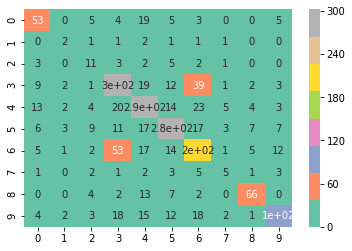

In [31]:
sns.heatmap(cm,
           annot=True,
           cmap="Set2")
plt.show()

In [30]:
from sklearn.metrics import classification_report


In [41]:
labelNames=['Biological','Fibres','Films Coated Surface','MEMS Devices and Electrodes','Nanowires','Particles','Patterned surface','Porous Sponge','Powder', 'Tips']
# evaluate the model
print("[INFO] evaluating model...")
predictions = model.predict(testData)
print(classification_report(testLabels,predictions, target_names=labelNames))

[INFO] evaluating model...
                             precision    recall  f1-score   support

                 Biological       0.96      0.99      0.97        94
                     Fibres       1.00      0.78      0.88         9
       Films Coated Surface       0.85      0.85      0.85        27
MEMS Devices and Electrodes       0.91      0.94      0.92       390
                  Nanowires       0.96      0.97      0.96       374
                  Particles       0.95      0.96      0.95       359
          Patterned surface       0.89      0.87      0.88       313
              Porous Sponge       0.90      0.83      0.86        23
                     Powder       0.97      0.91      0.94        94
                       Tips       0.93      0.86      0.89       175

                   accuracy                           0.93      1858
                  macro avg       0.93      0.90      0.91      1858
               weighted avg       0.93      0.93      0.93      1858



In [14]:
import itertools

Confusion matrix, without normalization
[[ 91   0   0   0   0   0   1   1   1   0]
 [  0   8   0   0   0   0   1   0   0   0]
 [  0   0  25   0   1   1   0   0   0   0]
 [  0   1   0 364   4   0  19   0   0   2]
 [  2   0   0   3 359   2   5   1   1   1]
 [  0   0   2   1   4 346   4   0   1   1]
 [  0   0   0  22   6   4 275   1   0   5]
 [  0   0   0   0   0   1   0  20   0   2]
 [  1   0   0   0   1   1   0   1  90   0]
 [  0   1   0   6   0   3   6   0   1 158]]


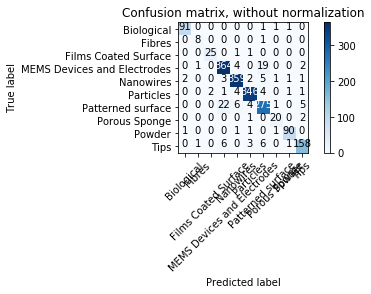

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# y_pred = model.predict(X_test)
# y_pred=np.argmax(y_pred, axis=1) 
# test_y=np.argmax(test_y, axis=1)

# print(y_pred)
# print(test_y)

# Compute confusion matrix
# cnf_matrix = confusion_matrix(test_y, y_pred)
# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=labelNames,
                      title='Confusion matrix, without normalization')

plt.show()
# plt.savefig('conf1.png')

# Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=labelNames, normalize=True,
#                       title='Normalized confusion matrix')
# plt.savefig('conf2.png')



In [42]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [43]:
cm_norm

array([[0.9893617 , 0.        , 0.        , 0.0106383 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.77777778, 0.        , 0.        , 0.11111111,
        0.        , 0.        , 0.        , 0.        , 0.11111111],
       [0.        , 0.        , 0.85185185, 0.        , 0.        ,
        0.07407407, 0.03703704, 0.        , 0.03703704, 0.        ],
       [0.        , 0.        , 0.        , 0.93846154, 0.00512821,
        0.00512821, 0.04358974, 0.        , 0.        , 0.00769231],
       [0.0026738 , 0.        , 0.        , 0.0026738 , 0.96791444,
        0.01069519, 0.01336898, 0.0026738 , 0.        , 0.        ],
       [0.        , 0.        , 0.01114206, 0.        , 0.00835655,
        0.96100279, 0.00835655, 0.        , 0.00557103, 0.00557103],
       [0.00319489, 0.        , 0.        , 0.0798722 , 0.02236422,
        0.00638978, 0.87220447, 0.        , 0.        , 0.01597444],
       [0.        , 0.        , 0.       

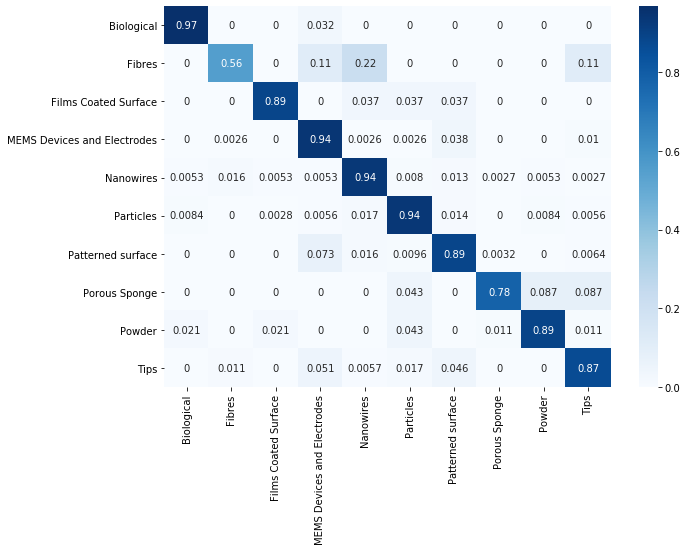

In [44]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[0.96808511, 0.        , 0.        , 0.03191489, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.55555556, 0.        , 0.11111111, 0.22222222,
        0.        , 0.        , 0.        , 0.        , 0.11111111],
       [0.        , 0.        , 0.88888889, 0.        , 0.03703704,
        0.03703704, 0.03703704, 0.        , 0.        , 0.        ],
       [0.        , 0.0025641 , 0.        , 0.94358974, 0.0025641 ,
        0.0025641 , 0.03846154, 0.        , 0.        , 0.01025641],
       [0.00534759, 0.01604278, 0.00534759, 0.00534759, 0.93582888,
        0.00802139, 0.01336898, 0.0026738 , 0.00534759, 0.0026738 ],
       [0.00835655, 0.        , 0.00278552, 0.00557103, 0.01671309,
        0.93871866, 0.01392758, 0.        , 0.00835655, 0.00557103],
       [0.        , 0.        , 0.        , 0.07348243, 0.01597444,
        0.00958466, 0.8913738 , 0.00319489, 0.        , 0.00638978],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.04347826, 0.        , 0.7826087 , 0.08695652, 0.08695652],
       [0.0212766 , 0.        , 0.0212766 , 0.        , 0.        ,
        0.04255319, 0.        , 0.0106383 , 0.89361702, 0.0106383 ],
       [0.        , 0.01142857, 0.        , 0.05142857, 0.00571429,
        0.01714286, 0.04571429, 0.        , 0.        , 0.86857143]]
df_cm = pd.DataFrame(array, index = [i for i in labelNames],
                  columns = [i for i in labelNames])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.savefig('norm_cm_mlp.png')

In [85]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input


from sklearn.linear_model import LogisticRegression
import numpy as np
import os
import pickle
import json


In [86]:
config={
    "model" : "vgg16",
    "weights": "imagenet",
    
    "features_path" : "./Model/features.h5",
    "labels_path" : "./Model/labels.h5",
    "classifier_path" : "./Model/classifier.pickle",
    "model_path" : "./Model/model",

}

In [87]:
print("[info] loading the classfier...")
classifier = pickle.load(open(config["classifier_path"], 'rb'))

if config["model"] == "vgg16":
    base_model = VGG16(weights=config["weights"])
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    image_size = (224,224)
    
else:
    base_model = None

[info] loading the classfier...


C:\Users\Mehrtoos\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  


In [105]:
img = image.load_img('./Data_Main/training/Powder/L4_0dff80e8f4630dacd8666764b6795feb.jpg', target_size=image_size)
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)
feature = model.predict(x)
flat = feature.flatten()
flat = np.expand_dims(flat, axis=0)
preds = classifier.predict(flat)

In [106]:
preds

array([8], dtype=int64)

In [107]:
train_labels

['Biological',
 'Fibres',
 'Films_Coated_Surface',
 'MEMS_devices_and_electrodes',
 'Nanowires',
 'Particles',
 'Patterned_surface',
 'Porous_Sponge',
 'Powder',
 'Tips']

In [108]:
label_check1 = train_labels

In [109]:
label_check1[preds[0]]

'Powder'